In [1]:
import numpy as np
import torch
import json
import pickle
import matplotlib.pyplot as plt
from matplotlib import cm
from os.path import join
from data_handler import load_dataset
from density_estimator import DensityEstimator
from evaluation_utils import minimum_validation_loss_models
from scipy.spatial.distance import jensenshannon
from scipy.stats import chi2
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve

# Where things are stored


In [2]:
data_basedir = "latentCATHODE_data/"
clsf_basedir = "latentCATHODE_trainings/"
results_dir = "latentCATHODE_results/"

# Background sculpting study

## Running evaluation

Compute-heavy part. Results will be stored on disk and thus the cells don't have to be rerun if the notebook is reloaded.

In [3]:
from bkg_sculpting_study import JSD_summary

# global settings
selection_efficiencies = np.arange(0.01, 0.21, 0.01)[::-1]
model_file_name = "my_ANODE_model"
num_DE_models = 1  # NOTE has to be 1 now!
num_clsf_models = 10
n_bins = 300
n_runs = 10
SR_percentile = True
SR_range = (3.3, 3.7)

settings = [
    {
        "mode": "latentCATHODE",
        "json_out_file": join(results_dir, "latentCATHODE_bkg-only.json"),
        "pdf_out_file": "bkg_sculpting_latentCATHODE_bkg-only_{}.pdf",
        "clsf_savedir": join(clsf_basedir, "latentCATHODE_bkg-only_{}"),
        "datadir": join(data_basedir, "no-shift_bkg-only/"),
        "config_file": "DE_MAF_model.yml",
    },
    {
        "mode": "latentCATHODE",
        "json_out_file": join(results_dir, "latentCATHODE_signal.json"),
        "pdf_out_file": "bkg_sculpting_latentCATHODE_signal_{}.pdf",
        "clsf_savedir": join(clsf_basedir, "latentCATHODE_signal_{}"),
        "datadir": join(data_basedir, "no-shift_signal/"),
        "config_file": "DE_MAF_model.yml",
    },
    {
        "mode": "latentCATHODE",
        "json_out_file": join(results_dir, "latentCATHODE_bkg-only_shifted.json"),
        "pdf_out_file": "bkg_sculpting_latentCATHODE_bkg-only_shifted_{}.pdf",
        "clsf_savedir": join(clsf_basedir, "latentCATHODE_bkg-only_shifted_{}"),
        "datadir": join(data_basedir, "shifted_bkg-only/"),
        "config_file": "DE_MAF_model.yml",
    },
    {
        "mode": "latentCATHODE",
        "json_out_file": join(results_dir, "latentCATHODE_signal_shifted.json"),
        "pdf_out_file": "bkg_sculpting_latentCATHODE_signal_shifted_{}.pdf",
        "clsf_savedir": join(clsf_basedir, "latentCATHODE_signal_shifted_{}"),
        "datadir": join(data_basedir, "shifted_signal/"),
        "config_file": "DE_MAF_model.yml",
    },
    {
        "mode": "latentCATHODE",
        "json_out_file": join(results_dir, "latentCATHODE_bkg-only_deltaR.json"),
        "pdf_out_file": "bkg_sculpting_latentCATHODE_bkg-only_deltaR_{}.pdf",
        "clsf_savedir": join(clsf_basedir, "latentCATHODE_bkg-only_deltaR_{}"),
        "datadir": join(data_basedir, "deltaR_bkg-only/"),
        "config_file": "DE_MAF_model_deltaR.yml",
    },
    {
        "mode": "latentCATHODE",
        "json_out_file": join(results_dir, "latentCATHODE_signal_deltaR.json"),
        "pdf_out_file": "bkg_sculpting_latentCATHODE_signal_deltaR_{}.pdf",
        "clsf_savedir": join(clsf_basedir, "latentCATHODE_signal_deltaR_{}"),
        "datadir": join(data_basedir, "deltaR_signal/"),
        "config_file": "DE_MAF_model_deltaR.yml",
    },
    {
        "mode": "classicCATHODE",
        "json_out_file": join(results_dir, "classicCATHODE_bkg-only.json"),
        "pdf_out_file": "bkg_sculpting_classicCATHODE_bkg-only_{}.pdf",
        "clsf_savedir": join(clsf_basedir, "classicCATHODE_bkg-only_{}"),
        "datadir": join(data_basedir, "no-shift_bkg-only/"),
        "config_file": "DE_MAF_model.yml",
    },
    {
        "mode": "classicCATHODE",
        "json_out_file": join(results_dir, "classicCATHODE_signal.json"),
        "pdf_out_file": "bkg_sculpting_classicCATHODE_signal_{}.pdf",
        "clsf_savedir": join(clsf_basedir, "classicCATHODE_signal_{}"),
        "datadir": join(data_basedir, "no-shift_signal/"),
        "config_file": "DE_MAF_model.yml",
    },
    {
        "mode": "classicCATHODE",
        "json_out_file": join(results_dir, "classicCATHODE_bkg-only_shifted.json"),
        "pdf_out_file": "bkg_sculpting_classicCATHODE_bkg-only_shifted_{}.pdf",
        "clsf_savedir": join(clsf_basedir, "classicCATHODE_bkg-only_shifted_{}"),
        "datadir": join(data_basedir, "shifted_bkg-only/"),
        "config_file": "DE_MAF_model.yml",
    },
    {
        "mode": "classicCATHODE",
        "json_out_file": join(results_dir, "classicCATHODE_signal_shifted.json"),
        "pdf_out_file": "bkg_sculpting_classicCATHODE_signal_shifted_{}.pdf",
        "clsf_savedir": join(clsf_basedir, "classicCATHODE_signal_shifted_{}"),
        "datadir": join(data_basedir, "shifted_signal/"),
        "config_file": "DE_MAF_model.yml",
    },
    {
        "mode": "classicCATHODE",
        "json_out_file": join(results_dir, "classicCATHODE_bkg-only_deltaR.json"),
        "pdf_out_file": "bkg_sculpting_classicCATHODE_bkg-only_deltaR_{}.pdf",
        "clsf_savedir": join(clsf_basedir, "classicCATHODE_bkg-only_deltaR_{}"),
        "datadir": join(data_basedir, "deltaR_bkg-only/"),
        "config_file": "DE_MAF_model_deltaR.yml",
    },
    {
        "mode": "classicCATHODE",
        "json_out_file": join(results_dir, "classicCATHODE_signal_deltaR.json"),
        "pdf_out_file": "bkg_sculpting_classicCATHODE_signal_deltaR_{}.pdf",
        "clsf_savedir": join(clsf_basedir, "classicCATHODE_signal_deltaR_{}"),
        "datadir": join(data_basedir, "deltaR_signal/"),
        "config_file": "DE_MAF_model_deltaR.yml",
    },
    {
        "mode": "idealizedAD",
        "json_out_file": join(results_dir, "idealizedAD_bkg-only.json"),
        "pdf_out_file": "bkg_sculpting_idealizedAD_bkg-only_{}.pdf",
        "clsf_savedir": join(clsf_basedir, "idealizedAD_bkg-only"),
        "datadir": join(data_basedir, "no-shift_bkg-only/"),
        "config_file": "",
    },
    {
        "mode": "idealizedAD",
        "json_out_file": join(results_dir, "idealizedAD_signal.json"),
        "pdf_out_file": "bkg_sculpting_idealizedAD_signal_{}.pdf",
        "clsf_savedir": join(clsf_basedir, "idealizedAD_signal"),
        "datadir": join(data_basedir, "no-shift_signal/"),
        "config_file": "",
    },
    {
        "mode": "idealizedAD",
        "json_out_file": join(results_dir, "idealizedAD_bkg-only_shifted.json"),
        "pdf_out_file": "bkg_sculpting_idealizedAD_bkg-only_shifted_{}.pdf",
        "clsf_savedir": join(clsf_basedir, "idealizedAD_bkg-only_shifted"),
        "datadir": join(data_basedir, "shifted_bkg-only/"),
        "config_file": "",
    },
    {
        "mode": "idealizedAD",
        "json_out_file": join(results_dir, "idealizedAD_signal_shifted.json"),
        "pdf_out_file": "bkg_sculpting_idealizedAD_signal_shifted_{}.pdf",
        "clsf_savedir": join(clsf_basedir, "idealizedAD_signal_shifted"),
        "datadir": join(data_basedir, "shifted_signal/"),
        "config_file": "",
    },
    {
        "mode": "idealizedAD",
        "json_out_file": join(results_dir, "idealizedAD_bkg-only_deltaR.json"),
        "pdf_out_file": "bkg_sculpting_idealizedAD_bkg-only_deltaR_{}.pdf",
        "clsf_savedir": join(clsf_basedir, "idealizedAD_bkg-only_deltaR"),
        "datadir": join(data_basedir, "deltaR_bkg-only/"),
        "config_file": "",
    },
    {
        "mode": "idealizedAD",
        "json_out_file": join(results_dir, "idealizedAD_signal_deltaR.json"),
        "pdf_out_file": "bkg_sculpting_idealizedAD_signal_deltaR_{}.pdf",
        "clsf_savedir": join(clsf_basedir, "idealizedAD_signal_deltaR"),
        "datadir": join(data_basedir, "deltaR_signal/"),
        "config_file": "",
    },
    {
        "mode": "stats",
        "json_out_file": join(results_dir, "stats_bkg-only.json"),
        "pdf_out_file": "",
        "clsf_savedir": "",
        "datadir": join(data_basedir, "no-shift_bkg-only/"),
        "config_file": "",
    },
    {
        "mode": "stats",
        "json_out_file": join(results_dir, "stats_signal.json"),
        "pdf_out_file": "",
        "clsf_savedir": "",
        "datadir": join(data_basedir, "no-shift_signal/"),
        "config_file": "",
    },
    {
        "mode": "stats",
        "json_out_file": join(results_dir, "stats_bkg-only_shifted.json"),
        "pdf_out_file": "",
        "clsf_savedir": "",
        "datadir": join(data_basedir, "shifted_bkg-only/"),
        "config_file": "",
    },
    {
        "mode": "stats",
        "json_out_file": join(results_dir, "stats_signal_shifted.json"),
        "pdf_out_file": "",
        "clsf_savedir": "",
        "datadir": join(data_basedir, "shifted_signal/"),
        "config_file": "",
    },
    {
        "mode": "stats",
        "json_out_file": join(results_dir, "stats_bkg-only_deltaR.json"),
        "pdf_out_file": "",
        "clsf_savedir": "",
        "datadir": join(data_basedir, "deltaR_bkg-only/"),
        "config_file": "",
    },
    {
        "mode": "stats",
        "json_out_file": join(results_dir, "stats_signal_deltaR.json"),
        "pdf_out_file": "",
        "clsf_savedir": "",
        "datadir": join(data_basedir, "deltaR_signal/"),
        "config_file": "",
    },
]

In [6]:
for setting in settings:
    if "veto_runs" in setting.keys():
        veto_runs = setting["veto_runs"]
    else:
        veto_runs = None
    JSD_summary(
        setting["datadir"], setting["clsf_savedir"],
        setting["json_out_file"], setting["pdf_out_file"],
        setting["mode"], selection_efficiencies,
        num_clsf_models=num_clsf_models, num_DE_models=num_DE_models,
        model_file_name=model_file_name,
        config_file=setting["config_file"], n_bins=n_bins, n_runs=n_runs,
        SR_percentile=SR_percentile, SR_range=SR_range,
        veto_runs=veto_runs
    )


DensityEstimator has 274800 parameters
Loading model parameters from latentCATHODE_trainings/latentCATHODE_bkg-only_1/my_ANODE_model_epoch_56.par
minimum validation loss epochs: [21 12 14 18 23 17 24 10  3  6]
saved as latentCATHODE_trainings/latentCATHODE_bkg-only_1/bkg_sculpting_latentCATHODE_bkg-only_1.pdf
DensityEstimator has 274800 parameters
Loading model parameters from latentCATHODE_trainings/latentCATHODE_bkg-only_2/my_ANODE_model_epoch_42.par
minimum validation loss epochs: [10 25 27 14 12 11  7  4  6 22]
saved as latentCATHODE_trainings/latentCATHODE_bkg-only_2/bkg_sculpting_latentCATHODE_bkg-only_2.pdf
DensityEstimator has 274800 parameters
Loading model parameters from latentCATHODE_trainings/latentCATHODE_bkg-only_3/my_ANODE_model_epoch_78.par
minimum validation loss epochs: [ 1 19  2 14 23  9  6 20  8 21]
saved as latentCATHODE_trainings/latentCATHODE_bkg-only_3/bkg_sculpting_latentCATHODE_bkg-only_3.pdf
DensityEstimator has 274800 parameters
Loading model parameters fro

## Chi2 plots

saved as latentCATHODE_results/chi2_comparison_bkg-only.pdf


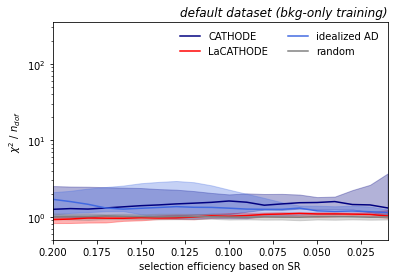

saved as latentCATHODE_results/chi2_comparison_bkg-only_shifted.pdf


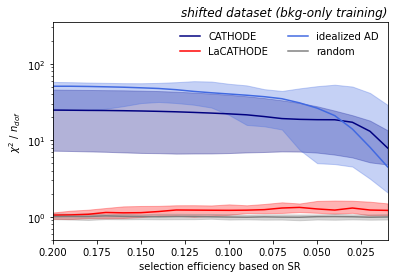

saved as latentCATHODE_results/chi2_comparison_bkg-only_deltaR.pdf


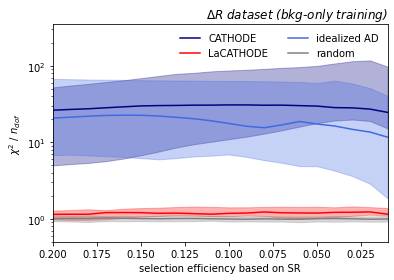

In [7]:
metric = "chi2"
n_bins = 300

methods = [
    "CATHODE",
    "LaCATHODE",
    "idealized AD",
    "random",
]
sel_effs = np.arange(0.01, 0.21, 0.01)[::-1]

datasets = [
    r"default dataset (bkg-only training)",
    r"shifted dataset (bkg-only training)",
    r"$\Delta R$ dataset (bkg-only training)",
    # r"default shifted (signal-injected training)",
    # r"shifted dataset (signal-injected training)",
    # r"$\Delta R$ dataset (signal-injected training)"
]

json_base = join(results_dir, "{method}_{dataset}.json")

color_dict = {
    "CATHODE": "navy",
    "LaCATHODE": "red",
    "idealized AD": "royalblue",
    "random": "grey",
}
linestyle_dict = {
    r"default dataset (bkg-only training)": "-",
    r"default shifted (signal-injected training)": "-",
    r"shifted dataset (bkg-only training)": "-",
    r"shifted dataset (signal-injected training)": "-",
    r"$\Delta R$ dataset (bkg-only training)": "-",
    r"$\Delta R$ dataset (signal-injected training)": "-"
}
method_dict = {
    "CATHODE": "classicCATHODE",
    "idealized AD": "idealizedAD",
    "LaCATHODE": "latentCATHODE",
    "random": "stats",
}

data_dict = {
    r"default dataset (bkg-only training)": "bkg-only",
    r"default shifted (signal-injected training)": "signal",
    r"shifted dataset (bkg-only training)": "bkg-only_shifted",
    r"shifted dataset (signal-injected training)": "signal_shifted",
    r"$\Delta R$ dataset (bkg-only training)": "bkg-only_deltaR",
    r"$\Delta R$ dataset (signal-injected training)": "signal_deltaR"
}

plt.clf()
for dataset in datasets:
    for method in methods:
        medians = []
        lower_bands = []
        upper_bands = []
        for sel_eff in sel_effs:
            with open(json_base.format(
                method=method_dict[method],
                dataset=data_dict[dataset]
            ), "rb") as f:
                json_content = json.load(f)
            medians.append(np.median(json_content[str(sel_eff)][metric]))
            lower_bands.append(np.quantile(json_content[str(sel_eff)][metric], 0.16))
            upper_bands.append(np.quantile(json_content[str(sel_eff)][metric], 0.84))

        medians = np.array(medians)
        lower_bands = np.array(lower_bands)
        upper_bands = np.array(upper_bands)
        plt.fill_between(sel_effs, lower_bands, upper_bands, color=color_dict[method], alpha=0.3)
        plt.plot(sel_effs, medians, color=color_dict[method], linestyle=linestyle_dict[dataset])

    for method in methods:
        plt.plot(np.nan, np.nan, label=method, color=color_dict[method], linestyle="-")

    plt.xlabel("selection efficiency based on SR")
    plt.ylabel(r"$\chi^2$ / $n_{dof}$")
    plt.yscale("log")
    plt.xlim(max(sel_effs), min(sel_effs))
    plt.ylim(0.5, 3.5e2)
    plt.legend(loc="upper right", frameon=False, ncol=2)
    plt.title(dataset, loc="right", style='italic')
    pdf_out_file = join(results_dir, f"{metric}_comparison_{data_dict[dataset]}.pdf")
    plt.savefig(pdf_out_file)
    print(f"saved as {pdf_out_file}")
    plt.show()

The chi2 plots quantify the shape difference between the background distribution before and after a cut on the anomaly score, corresponding to selecting the X% most anomalous events in the signal region, as a function of X.

We see that there is a noticeable but not-so-large sculpting for CATHODE and the idealized anomaly detector in the case of the original input features, which are not strongly correlated with the dijet mass.

However, once we introduce such a correlation, either with an artificial shift or by adding a phyiscally correlated feature, the chi2 becomes very large. On the other hand, LaCATHODE retains the background shape very well, as seen by the low and flat chi2 vs X.

saved as latentCATHODE_results/bkg_sculpting_comparison_bkg-only_sel0.20.pdf


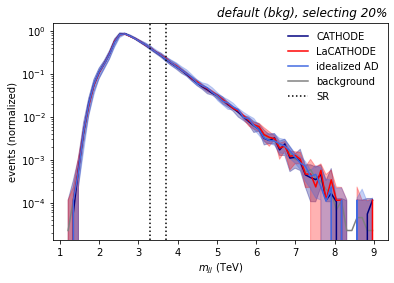

saved as latentCATHODE_results/bkg_sculpting_comparison_bkg-only_sel0.10.pdf


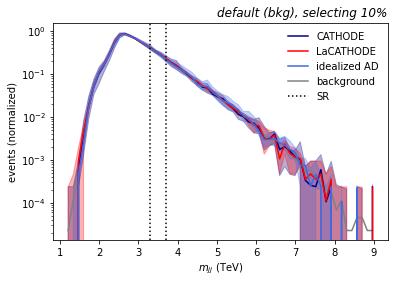

saved as latentCATHODE_results/bkg_sculpting_comparison_bkg-only_sel0.05.pdf


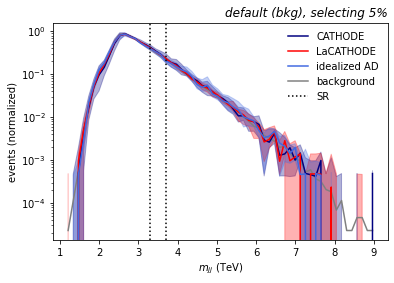

saved as latentCATHODE_results/bkg_sculpting_comparison_bkg-only_sel0.01.pdf


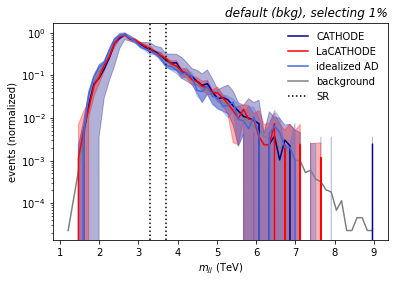

saved as latentCATHODE_results/bkg_sculpting_comparison_bkg-only_shifted_sel0.20.pdf


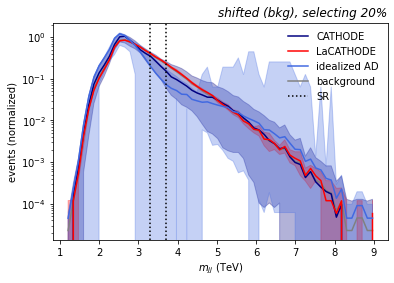

saved as latentCATHODE_results/bkg_sculpting_comparison_bkg-only_shifted_sel0.10.pdf


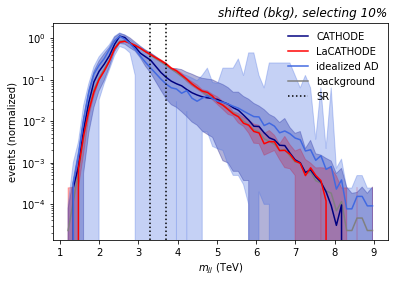

saved as latentCATHODE_results/bkg_sculpting_comparison_bkg-only_shifted_sel0.05.pdf


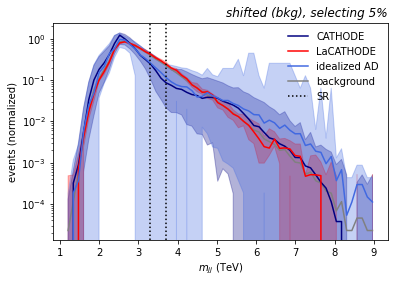

saved as latentCATHODE_results/bkg_sculpting_comparison_bkg-only_shifted_sel0.01.pdf


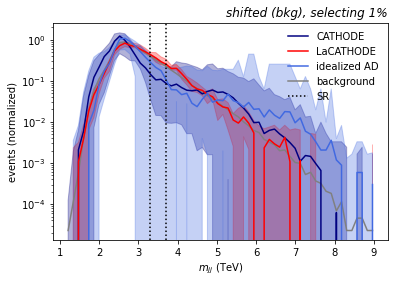

saved as latentCATHODE_results/bkg_sculpting_comparison_bkg-only_deltaR_sel0.20.pdf


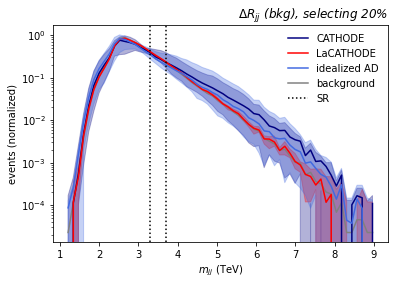

saved as latentCATHODE_results/bkg_sculpting_comparison_bkg-only_deltaR_sel0.10.pdf


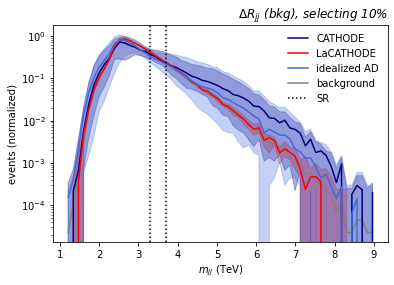

saved as latentCATHODE_results/bkg_sculpting_comparison_bkg-only_deltaR_sel0.05.pdf


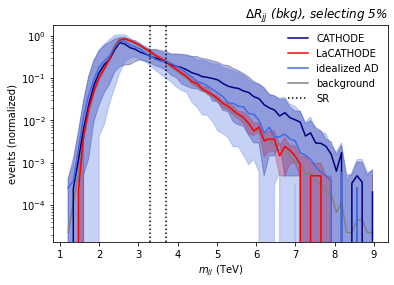

saved as latentCATHODE_results/bkg_sculpting_comparison_bkg-only_deltaR_sel0.01.pdf


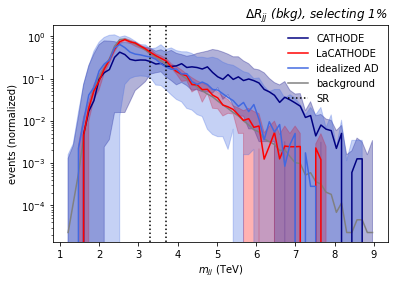

In [8]:
## distributions with bands

sel_effs = [0.2, 0.1, 0.05, 0.01]
methods = [
    "CATHODE",
    "LaCATHODE",
    "idealized AD",
]
n_runs = 10
n_bins = 60
band_width = (0., 1.)
sr_width = (3.3, 3.7)

datasets = [
    r"default (bkg)",
    r"shifted (bkg)",
    r"$\Delta R_{jj}$ (bkg)",
    # r"default (bkg+sig)",
    # r"shifted (bkg+sig)",
    # r"$\Delta R_{jj}$ (bkg+sig)"
]

color_dict = {
    "CATHODE": "navy",
    "LaCATHODE": "red",
    "idealized AD": "royalblue",
    "background": "grey",
}
linestyle_dict = {
    r"default (bkg)": "-",
    r"default (bkg+sig)": "-",
    r"shifted (bkg)": "-",
    r"shifted (bkg+sig)": "-",
    r"$\Delta R_{jj}$ (bkg)": "-",
    r"$\Delta R_{jj}$ (bkg+sig)": "-"
}
method_dict = {
    "CATHODE": "classicCATHODE",
    "idealized AD": "idealizedAD",
    "LaCATHODE": "latentCATHODE",
    "random": "stats",
}
test_data_dict = {
    r"default (bkg)": "no-shift_bkg-only",
    r"default (bkg+sig)": "no-shift_signal",
    r"shifted (bkg)": "shifted_bkg-only",
    r"shifted (bkg+sig)": "shifted_signal",
    r"$\Delta R_{jj}$ (bkg)": "deltaR_bkg-only",
    r"$\Delta R_{jj}$ (bkg+sig)": "deltaR_signal"
}
data_dict = {
    r"default (bkg)": "bkg-only",
    r"default (bkg+sig)": "signal",
    r"shifted (bkg)": "bkg-only_shifted",
    r"shifted (bkg+sig)": "signal_shifted",
    r"$\Delta R_{jj}$ (bkg)": "bkg-only_deltaR",
    r"$\Delta R_{jj}$ (bkg+sig)": "signal_deltaR"
}

data_string = join(clsf_basedir, "{method}_{dataset}{run_number_1}/bkg_sculpting_{method}_{dataset}_{run_number_2}_sel{sel_eff:.2f}.npy")

for dataset in datasets:
    for sel_eff in sel_effs:
        datadir = join(data_basedir, f"{test_data_dict[dataset]}/")
        test_data = np.vstack((
            np.load(join(datadir, "innerdata_test.npy")),
            np.load(join(datadir, "outerdata_test.npy"))
        )).astype("float32")

        data_hist, binning = np.histogram(test_data[:, 0], n_bins, density=True)
        plt.plot(0.5*(binning[:-1]+binning[1:]), data_hist, color=color_dict["background"], linestyle="-")

        for method in methods:
            selected_hists = []
            for run in range(1, n_runs+1):
                current_hist, _ = np.histogram(
                    np.load(data_string.format(method=method_dict[method], dataset=data_dict[dataset], run_number_1="" if method=="idealized AD" else f"_{run}", run_number_2=run, sel_eff=sel_eff)),
                    binning, density=True
                )
                selected_hists.append(current_hist)

            hist_stack = np.stack(selected_hists, axis=0)
            median_hist = np.median(hist_stack, axis=0)
            lower_band_hist = np.quantile(hist_stack, band_width[0], axis=0)
            upper_band_hist = np.quantile(hist_stack, band_width[1], axis=0)

            plt.fill_between(0.5*(binning[:-1]+binning[1:]), lower_band_hist, upper_band_hist, color=color_dict[method], alpha=0.3)
            plt.plot(0.5*(binning[:-1]+binning[1:]), median_hist, color=color_dict[method], linestyle="-")

        plt.axvline(x=sr_width[0], color="black", linestyle=":")
        plt.axvline(x=sr_width[1], color="black", linestyle=":")

        for method in methods:
            plt.plot(np.nan, np.nan, label=method, color=color_dict[method], linestyle="-")
        plt.plot(np.nan, np.nan, label="background", color=color_dict["background"], linestyle="-")
        plt.plot(np.nan, np.nan, label="SR", color="black", linestyle=":")

        plt.xlabel(r"$m_{jj}$ (TeV)")
        plt.ylabel("events (normalized)")
        plt.yscale("log")
        plt.legend(loc="upper right", frameon=False)
        plt.title(f"{dataset}, selecting {100*sel_eff:.0f}%", loc="right", style='italic')
        pdf_out_file = join(results_dir, f"bkg_sculpting_comparison_{data_dict[dataset]}_sel{sel_eff:.2f}.pdf")
        plt.savefig(pdf_out_file)
        print(f"saved as {pdf_out_file}")
        plt.show()

The shape difference can be displayed explicitly. In the plots above, all the 10 independent runs are shown as medians with bands stretching from the minimum to the maximum.

We again see a much more stable background shape for LaCATHODE, while the data space methods show both a bias and a large variance.

Unfortunately, the plots also somewhat obscure the individual dijet mass shape that one would get in an analysis by running (La)CATHODE once. Let's also look at what a single one of these spectra looks like below.

saved as latentCATHODE_results/bkg_sculpting_comparison_indiv_bkg-only_sel0.01_1.pdf


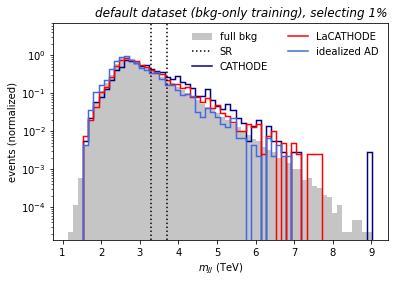

saved as latentCATHODE_results/bkg_sculpting_comparison_indiv_bkg-only_shifted_sel0.01_1.pdf


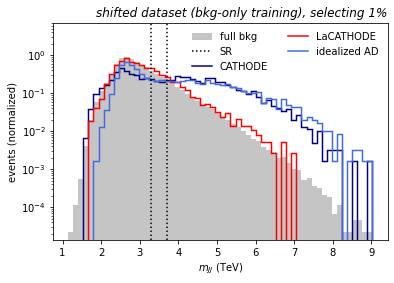

saved as latentCATHODE_results/bkg_sculpting_comparison_indiv_bkg-only_deltaR_sel0.01_1.pdf


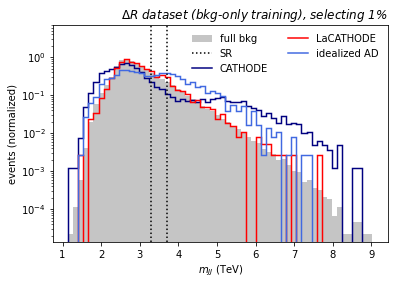

In [9]:
sel_effs = [
    # 0.2,
    # 0.1,
    # 0.05,
    0.01,
]
methods = [
    "CATHODE",
    "LaCATHODE",
    "idealized AD",
]
n_runs_start = 1
n_runs_end = n_runs_start + 1
n_bins = 60
sr_width = (3.3, 3.7)

datasets = [
    r"default dataset (bkg-only training)",
    r"shifted dataset (bkg-only training)",
    r"$\Delta R$ dataset (bkg-only training)",
    # r"default dataset (signal-injected training)",
    # r"shifted dataset (signal-injected training)",
    # r"$\Delta R$ dataset (signal-injected training)"
]

color_dict = {
    "CATHODE": "navy",
    "LaCATHODE": "red",
    "idealized AD": "royalblue",
    "background": "grey",
    "decorrCATHODE": "orange"
}
linestyle_dict = {
    r"default dataset (bkg-only training)": "-",
    r"default dataset (signal-injected training)": "-",
    r"shifted dataset (bkg-only training)": "-",
    r"shifted dataset (signal-injected training)": "-",
    r"$\Delta R$ dataset (bkg-only training)": "-",
    r"$\Delta R$ dataset (signal-injected training)": "-"
}
method_dict = {
    "CATHODE": "classicCATHODE",
    "idealized AD": "idealizedAD",
    "LaCATHODE": "latentCATHODE",
    "random": "stats",
}
test_data_dict = {
    r"default dataset (bkg-only training)": "no-shift_bkg-only",
    r"default dataset (signal-injected training)": "no-shift_signal",
    r"shifted dataset (bkg-only training)": "shifted_bkg-only",
    r"shifted dataset (signal-injected training)": "shifted_signal",
    r"$\Delta R$ dataset (bkg-only training)": "deltaR_bkg-only",
    r"$\Delta R$ dataset (signal-injected training)": "deltaR_signal"
}
data_dict = {
    r"default dataset (bkg-only training)": "bkg-only",
    r"default dataset (signal-injected training)": "signal",
    r"shifted dataset (bkg-only training)": "bkg-only_shifted",
    r"shifted dataset (signal-injected training)": "signal_shifted",
    r"$\Delta R$ dataset (bkg-only training)": "bkg-only_deltaR",
    r"$\Delta R$ dataset (signal-injected training)": "signal_deltaR"
}

data_string = join(clsf_basedir, "{method}_{dataset}{run_number_1}/bkg_sculpting_{method}_{dataset}_{run_number_2}_sel{sel_eff:.2f}.npy")

for dataset in datasets:

    for sel_eff in sel_effs:

        ax1 = plt.axes()

        datadir = join(data_basedir, f"{test_data_dict[dataset]}/")
        test_data = np.vstack((
            np.load(join(datadir, "innerdata_test.npy")),
            np.load(join(datadir, "outerdata_test.npy"))
        )).astype("float32")

        data_hist, binning, _ = ax1.hist(test_data[:, 0], n_bins, density=True, color=color_dict["background"], alpha=0.45, label="full bkg")
        full_data_hist, _ = np.histogram(test_data[:, 0], binning)
        norm_factor = 1 / (sel_eff * sum(full_data_hist) * np.diff(binning))

        ax1.plot(np.nan, np.nan, label="SR", color="black", linestyle=":")

        for method in methods:
            selected_hists = []
            for run in range(n_runs_start, n_runs_end):
                current_hist, _, _ = ax1.hist(
                    np.load(data_string.format(method=method_dict[method], dataset=data_dict[dataset], run_number_1="" if method=="idealized AD" else f"_{run}", run_number_2=run, sel_eff=sel_eff)),
                    binning, density=True, color=color_dict[method], histtype="step", linewidth=1.48
                )
                pulls = ((current_hist - data_hist)**2)/((norm_factor**2)*sel_eff*full_data_hist)
                pulls = ((current_hist - data_hist)**2)/((norm_factor**2)*sel_eff*full_data_hist)

        ax1.axvline(x=sr_width[0], color="black", linestyle=":")
        ax1.axvline(x=sr_width[1], color="black", linestyle=":")

        for method in methods:
            ax1.plot(np.nan, np.nan, label=method, color=color_dict[method], linestyle="-")

        ax1.set_xlabel(r"$m_{JJ}$ (TeV)")
        ax1.set_ylabel("events (normalized)")
        ax1.set_yscale("log")
        ax1.set_ylim(None, 7)
        ax1.legend(loc="upper right", frameon=False, ncol=2)
        ax1.set_title(f"{dataset}, selecting {100*sel_eff:.0f}%", loc="right", style='italic')
        pdf_out_file = join(results_dir, f"bkg_sculpting_comparison_indiv_{data_dict[dataset]}_sel{sel_eff:.2f}_{n_runs_start}.pdf")
        plt.savefig(pdf_out_file)
        print(f"saved as {pdf_out_file}")
        plt.show()

# SIC Curves

## Evaluating each run

Compute-heavy part. Results will be stored on disk and thus the cells don't have to be rerun if the notebook is reloaded.

In [10]:
def save_to_json(file_name, dictionary):
    with open(file_name, "w") as outfile:
        json.dump(dictionary, outfile)
    print(f"saved as {file_name}")

### Make ROCs for each run

In [11]:
np.seterr(all="ignore")
def make_ROCs(clsf_basedir, datadir, run_numbers, pdf_out_file, pickle_out_file, latent_evaluation, config_file="DE_MAF_model.yml", model_file_name="my_ANODE_model", num_DE_models=1, num_clsf_models=10, multirun=False):
    
    tprs = []
    fprs = []
    for run_number in run_numbers:

        if multirun:
            effective_run_number = run_number-1
            clsf_savedir = clsf_basedir
        else:
            effective_run_number = 0
            clsf_savedir = clsf_basedir.format(run_number=run_number)

        innerdata_eval = np.vstack((
            np.load(join(datadir, "innerdata_test.npy")),
            np.load(join(datadir, "innerdata_extrabkg_test.npy")),
            np.load(join(datadir, "innerdata_extrasig.npy")),
        )).astype("float32")

        test_data = innerdata_eval

        ## everything below should be identical to before

        # prepare classifier data (e.g. mapping to latent space)
        if latent_evaluation:
            outer_traindata = np.load(
                join(datadir, "outerdata_train.npy")
            ).astype("float32")
            outer_traindict = load_dataset(outer_traindata)
            prep_datadict = load_dataset(test_data, external_datadict=outer_traindict)
            DE_val_losses = np.load(
                join(clsf_savedir, model_file_name+"_val_losses.npy")
            )
            idx = np.argpartition(DE_val_losses, num_DE_models)[:num_DE_models]
            model_path = join(
                clsf_savedir, model_file_name+'_epoch_'+str(idx[0]-1)+'.par'
            )
            model = DensityEstimator(config_file, eval_mode=True,
                                     load_path=model_path).model
            clsf_data = model(
                prep_datadict["tensor2"], prep_datadict["labels"]
            )[0].detach().cpu().numpy()
        else:
            inner_traindata = np.load(
                join(datadir, "innerdata_train.npy")
            ).astype("float32")[:, 1: -1]
            mean = np.mean(inner_traindata, axis=0)
            std = np.std(inner_traindata, axis=0)
            clsf_data = (test_data[:, 1: -1] - mean) / std

        # get classifier score
        clsf_model_paths = minimum_validation_loss_models(
            clsf_savedir, n_epochs=num_clsf_models
        )[effective_run_number]
        use_cuda = False  # torch.cuda.is_available()
        device = torch.device("cuda:0" if use_cuda else "cpu")
        predictions = []
        for model_path in clsf_model_paths:
            clsf_model = torch.load(model_path, map_location=device)
            clsf_model.eval()
            predictions.append(clsf_model.predict(clsf_data).flatten())
        mean_predictions = np.mean(np.stack(predictions, axis=0), axis=0)

        if latent_evaluation:
            masked_data = test_data[prep_datadict["mask"].detach().cpu().numpy()]
        else:
            masked_data = test_data

        preds_mask = (~np.isnan(mean_predictions)) & (~np.isinf(mean_predictions))      
       
        fpr, tpr, thr = roc_curve(masked_data[:, -1][preds_mask], mean_predictions[preds_mask])
        fprs.append(fpr)
        tprs.append(tpr)

    # saving results as a pickle file
    results_dict = {
        "fprs": fprs,
        "tprs": tprs
    }
    with open(pickle_out_file, "wb") as f:
        pickle.dump(results_dict, f)
    print(f"Saved numeric results as {pickle_out_file}")

    # draw SIC curves
    plt.clf()
    for i, run_number in enumerate(run_numbers):
        plt.plot(tprs[i], tprs[i]*(fprs[i]**(-0.5)), label=f"run {run_number}")
    plt.xlim(0, 1)
    plt.ylim(0, 20)
    plt.legend(loc="upper right")
    plt.xlabel("True Positive Rate")
    plt.ylabel("Significance Improvement")
    plt.savefig(pdf_out_file)
    print(f"saved as {pdf_out_file}")

In [12]:
settings = [
    {
        "datadir": join(data_basedir, "no-shift_signal"),
        "clsf_basedir": join(clsf_basedir, "latentCATHODE_signal_{run_number}"),
        "pdf_out_file": join(results_dir, "SIC_latentCATHODE.pdf"),
        "pickle_out_file": join(results_dir, "SIC_latentCATHODE.pkl"),
        "run_numbers": range(1, 11),
        "config_file": "DE_MAF_model.yml",
        "latent_evaluation": True,
    },
    {
        "datadir": join(data_basedir, "shifted_signal"),
        "clsf_basedir": join(clsf_basedir, "latentCATHODE_signal_shifted_{run_number}"),
        "pdf_out_file": join(results_dir, "SIC_latentCATHODE_shifted.pdf"),
        "pickle_out_file": join(results_dir, "SIC_latentCATHODE_shifted.pkl"),
        "run_numbers": range(1, 11),
        "config_file": "DE_MAF_model.yml",
        "latent_evaluation": True,
    },
    {
        "datadir": join(data_basedir, "deltaR_signal"),
        "clsf_basedir": join(clsf_basedir, "latentCATHODE_signal_deltaR_{run_number}"),
        "pdf_out_file": join(results_dir, "SIC_latentCATHODE_deltaR.pdf"),
        "pickle_out_file": join(results_dir, "SIC_latentCATHODE_deltaR.pkl"),
        "run_numbers": range(1, 11),
        "config_file": "DE_MAF_model_deltaR.yml",
        "latent_evaluation": True,
    },
    {
        "datadir": join(data_basedir, "no-shift_signal"),
        "clsf_basedir": join(clsf_basedir, "classicCATHODE_signal_{run_number}"),
        "pdf_out_file": join(results_dir, "SIC_classicCATHODE.pdf"),
        "pickle_out_file": join(results_dir, "SIC_classicCATHODE.pkl"),
        "run_numbers": range(1, 11),
        "config_file": "",
        "latent_evaluation": False,
    },
    {
        "datadir": join(data_basedir, "shifted_signal"),
        "clsf_basedir": join(clsf_basedir, "classicCATHODE_signal_shifted_{run_number}"),
        "pdf_out_file": join(results_dir, "SIC_classicCATHODE_shifted.pdf"),
        "pickle_out_file": join(results_dir, "SIC_classicCATHODE_shifted.pkl"),
        "run_numbers": range(1, 11),
        "config_file": "",
        "latent_evaluation": False,
    },
    {
        "datadir": join(data_basedir, "deltaR_signal"),
        "clsf_basedir": join(clsf_basedir, "classicCATHODE_signal_deltaR_{run_number}"),
        "pdf_out_file": join(results_dir, "SIC_classicCATHODE_deltaR.pdf"),
        "pickle_out_file": join(results_dir, "SIC_classicCATHODE_deltaR.pkl"),
        "run_numbers": range(1, 11),
        "config_file": "",
        "latent_evaluation": False,
    },
    {
        "datadir": join(data_basedir, "no-shift_signal"),
        "clsf_basedir": join(clsf_basedir, "idealizedAD_signal"),
        "pdf_out_file": join(results_dir, "SIC_idealizedAD.pdf"),
        "pickle_out_file": join(results_dir, "SIC_idealizedAD.pkl"),
        "run_numbers": range(1, 11),
        "config_file": "",
        "latent_evaluation": False,
        "multirun": True,
    },
    {
        "datadir": join(data_basedir, "shifted_signal"),
        "clsf_basedir": join(clsf_basedir, "idealizedAD_signal_shifted"),
        "pdf_out_file": join(results_dir, "SIC_idealizedAD_shifted.pdf"),
        "pickle_out_file": join(results_dir, "SIC_idealizedAD_shifted.pkl"),
        "run_numbers": range(1, 11),
        "config_file": "",
        "latent_evaluation": False,
        "multirun": True,
    },
    {
        "datadir": join(data_basedir, "deltaR_signal"),
        "clsf_basedir": join(clsf_basedir, "idealizedAD_signal_deltaR"),
        "pdf_out_file": join(results_dir, "SIC_idealizedAD_deltaR.pdf"),
        "pickle_out_file": join(results_dir, "SIC_idealizedAD_deltaR.pkl"),
        "run_numbers": range(1, 11),
        "config_file": "",
        "latent_evaluation": False,
        "multirun": True,
    },
]

In [13]:
for setting in settings:
    if "multirun" in setting.keys() and setting["multirun"]:
        multirun = True
    else:
        multirun = False
    make_ROCs(setting["clsf_basedir"], setting["datadir"], setting["run_numbers"], setting["pdf_out_file"], setting["pickle_out_file"], setting["latent_evaluation"], config_file=setting["config_file"], multirun=multirun)

DensityEstimator has 274800 parameters
Loading model parameters from latentCATHODE_trainings/latentCATHODE_signal_1/my_ANODE_model_epoch_37.par
minimum validation loss epochs: [24 26 15 12 13 17 19 22 14 21]
DensityEstimator has 274800 parameters
Loading model parameters from latentCATHODE_trainings/latentCATHODE_signal_2/my_ANODE_model_epoch_71.par
minimum validation loss epochs: [19 15 17 11 10  5 12  7  1  0]
DensityEstimator has 274800 parameters
Loading model parameters from latentCATHODE_trainings/latentCATHODE_signal_3/my_ANODE_model_epoch_51.par
minimum validation loss epochs: [16 13 19 14 15 24 20 11  7  4]
DensityEstimator has 274800 parameters
Loading model parameters from latentCATHODE_trainings/latentCATHODE_signal_4/my_ANODE_model_epoch_46.par
minimum validation loss epochs: [22 13 25 27 16 19 37  8 35 14]
DensityEstimator has 274800 parameters
Loading model parameters from latentCATHODE_trainings/latentCATHODE_signal_5/my_ANODE_model_epoch_67.par
minimum validation loss 

## Compare median SICs

In [14]:
COLOR_CODE = {"CATHODE": "magenta", "CWoLa": "orange", "ANODE": "blue", "Supervised": "green", "Idealized_AD": "darkslategray"}
SINGLE_COLOR_CODE = {"CATHODE": "violet", "CWoLa": "navajowhite", "ANODE": "skyblue", "Supervised": "lightgreen", "Idealized_AD": "lightslategray"}

for method in list(COLOR_CODE.keys()):
    COLOR_CODE[method+"_mjj"] = COLOR_CODE[method]
for method in list(SINGLE_COLOR_CODE.keys()):
    SINGLE_COLOR_CODE[method+"_mjj"] = SINGLE_COLOR_CODE[method]

np.seterr(all="ignore")
def compute_median_and_variance_roc_sic(tprs_list, fprs_list, resolution=10000, mean=False, extended_range=False, fpr_cutoff=0, vs_fpr=False):

    # took out ROCs but left the return values for now

    # interpolation
    axis_list = fprs_list if vs_fpr else tprs_list
    max_min_val = 0.
    min_max_val = 1.
    if not extended_range:
        for axis_vals in axis_list:
            if min(axis_vals) > max_min_val:
                max_min_val = min(axis_vals)
            if max(axis_vals) < min_max_val:
                min_max_val = max(axis_vals)
    if vs_fpr:
        axis_manual = np.logspace(np.log10(1e-4), np.log10(min_max_val), resolution)
    else:
        axis_manual = np.linspace(max_min_val, min_max_val, resolution)

    roc_interpol = []
    sic_interpol = []
    for tpr, fpr in zip(tprs_list, fprs_list):
        fpr_mask = fpr>fpr_cutoff
        tpr_vals = tpr[fpr_mask]
        fpr_vals = fpr[fpr_mask]
        axis_vals = fpr_vals if vs_fpr else tpr_vals
        sic_function = interp1d(axis_vals, tpr_vals/(fpr_vals**(0.5)), bounds_error=False)
        sic_interpol.append(sic_function(axis_manual))
                     
    # ensure at least 5 lines for a point to be considered
    sic_matrix = np.stack(sic_interpol)
    sic_line_count = np.count_nonzero(~np.isnan(sic_matrix), axis=0)
    total_count = sic_line_count
    sic_matrix = sic_matrix[:,total_count>=5]
    axis_manual = axis_manual[total_count>=5]    
            
    # calculating mean+std or median+quantiles
    if mean:
        sic_median = np.nanmean(sic_matrix, axis=0)
        sic_std = np.nanstd(sic_matrix, axis=0)
        sic_std = (sic_median-sic_std, sic_median+sic_std)
    else:
        sic_median = np.nanmedian(sic_matrix, axis=0)
        sic_std = (np.nanquantile(sic_matrix, 0.16, axis=0), np.nanquantile(sic_matrix, 0.84, axis=0))
    
    roc_median = None
    roc_std = None

    return axis_manual, roc_median, sic_median, roc_std, sic_std

def variation_plots(line_dictionary, methods=["CATHODE", "CWoLa", "ANODE", "Idealized_AD", "Supervised"], draw_bands=True, draw_single_lines=False, title_suffix=None, labels=None, color_dict=None, single_color_dict=None, sic_range=(0, 23), savefig=None, resolution=1000, suppress_random=False, vs_fpr=False):

    # took out ROCs but left the return values for now

    tprs_list = []
    ROCs_list = []
    SICs_list = []
    ROC_std_list = []
    SIC_std_list = []
    colors = []
    mjj_line = False
    noise_mjj_line = False
    if color_dict is None:
        color_dict = COLOR_CODE
        single_color_dict = SINGLE_COLOR_CODE
       
    ## derive the median and the std of each method's line collection
    for method in methods:
        single_tprs = []
        single_fprs = []
        for line in line_dictionary[method]:
            single_tprs.append(line[0])
            single_fprs.append(line[1])
        tpr_manual, roc_median, sic_median, roc_std, sic_std = compute_median_and_variance_roc_sic(single_tprs, single_fprs, resolution=resolution, mean=False, extended_range=True, fpr_cutoff=1.6173483250740743e-05, vs_fpr=vs_fpr)
        tprs_list.append(tpr_manual)
        ROCs_list.append(roc_median)
        SICs_list.append(sic_median)
        ROC_std_list.append(roc_std)
        SIC_std_list.append(sic_std)
        colors.append(color_dict[method]) 
        if "noise_mjj" in method:
            noise_mjj_line=True
        elif "mjj" in method:
            mjj_line=True
    
    if title_suffix is None:
        title_suffix = ""
    else:
        title_suffix = ", "+title_suffix
    
    if labels is None:
        labels = methods.copy()
        for i in range(len(labels)):
            labels[i] = labels[i].replace("_"," ")
    
    if draw_bands:
        for i, method in enumerate(methods):
            plt.fill_between(tprs_list[i], SIC_std_list[i][0], SIC_std_list[i][1], color=colors[i], alpha=0.3)
    if draw_single_lines:
        for i, method in enumerate(methods):
            for line in line_dictionary[method]:
                if "noise_mjj" in method:
                    linestyle = ":"
                elif "mjj" in method:
                    linestyle = "--"
                else:
                    linestyle = "-"
                plt.plot(line[0], line[0]*(line[1]**(-0.5)), color=single_color_dict[method], linestyle=linestyle)    
    for i, method in enumerate(methods):
        if "noise_mjj" in method:
            linestyle = ":"
        elif "mjj" in method:
            linestyle = "--"
        else:
            linestyle = "-"
        plt.plot(tprs_list[i], SICs_list[i], color=colors[i], label=labels[i], linestyle=linestyle)
        # print(f"max SIC of {method} is {max(SICs_list[i])}")
    if mjj_line:
        plt.plot(np.nan, np.nan, color="black", linestyle="--", label=r"using $m_{jj}$ input")
    if noise_mjj_line:
        plt.plot(np.nan, np.nan, color="black", linestyle=":", label=r"using gaussian noise input")
    elif not suppress_random:
        plt.plot(np.linspace(0.00001,1,3000), np.linspace(0.00001,1,3000)/np.linspace(0.00001,1,3000)**(0.5), color="grey", linestyle="-", label="random")
    plt.ylim(sic_range)
    plt.ylabel('Significance Improvement')
    if vs_fpr:
        plt.xscale("log")
        plt.xlim(1e-4, 1.)
        plt.xlabel('Background Efficiency (False Positive Rate)')
    else:
        plt.xlabel('Signal Efficiency (True Positive Rate)')
    plt.legend(loc = 'upper right', frameon=False)
    plt.title(f"Signal Region"+title_suffix, loc="right", style='italic')

    # save / display
    # plt.subplots_adjust(right=2.0)
    if savefig is not None:
        # plt.savefig(savefig, bbox_inches="tight")
        plt.savefig(savefig)
    plt.show()

In [15]:
methods = ["classicCATHODE", "latentCATHODE", "idealizedAD"]
labels = ["CATHODE", "LaCATHODE", "idealized AD"]
color_dict = {
    "classicCATHODE": "navy",
    "latentCATHODE": "red",
    "idealizedAD": "royalblue"
}

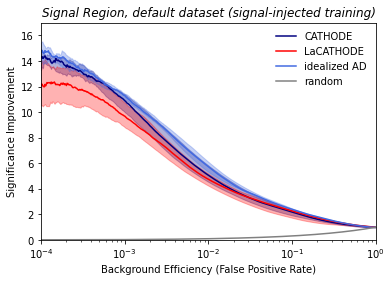

In [16]:
dataset = ""

# gather into input format for comparison function
line_dict = {}
for method in methods:
    pickle_in_file = join(results_dir, f"SIC_{method}{dataset}.pkl")
    with open(pickle_in_file, "rb") as f:
        fprs_tprs = pickle.load(f)
    line_dict[method] = [x for x in zip(fprs_tprs["tprs"], fprs_tprs["fprs"])]

# comparison function
variation_plots(line_dict, methods=methods, labels=labels, color_dict=color_dict, draw_bands=True, sic_range=(0,17), title_suffix="default dataset (signal-injected training)", savefig=join(results_dir, "SIC_comparison_default.pdf"), vs_fpr=True, resolution=500)

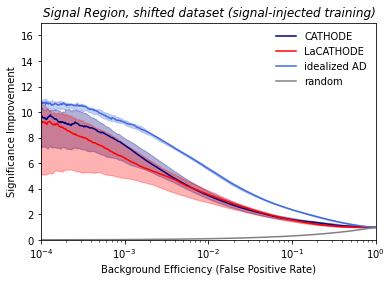

In [17]:
dataset = "_shifted"

# gather into input format for comparison function
line_dict = {}
for method in methods:
    pickle_in_file = f"latentCATHODE_results/SIC_{method}{dataset}.pkl"
    with open(pickle_in_file, "rb") as f:
        fprs_tprs = pickle.load(f)
    line_dict[method] = [x for x in zip(fprs_tprs["tprs"], fprs_tprs["fprs"])]

# comparison function
variation_plots(line_dict, methods=methods, labels=labels, color_dict=color_dict, draw_bands=True, sic_range=(0,17), title_suffix="shifted dataset (signal-injected training)", savefig=join(results_dir, "SIC_comparison_shifted.pdf"), vs_fpr=True, resolution=500)

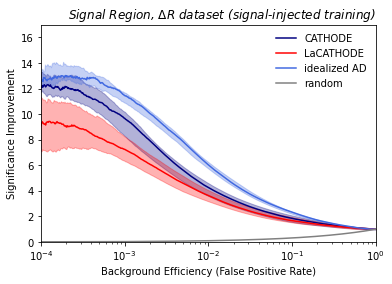

In [18]:
dataset = "_deltaR"

# gather into input format for comparison function
line_dict = {}
for method in methods:
    pickle_in_file = f"latentCATHODE_results/SIC_{method}{dataset}.pkl"
    with open(pickle_in_file, "rb") as f:
        fprs_tprs = pickle.load(f)
    line_dict[method] = [x for x in zip(fprs_tprs["tprs"], fprs_tprs["fprs"])]

# comparison function
variation_plots(line_dict, methods=methods, labels=labels, color_dict=color_dict, draw_bands=True, sic_range=(0,17), title_suffix=r"$\Delta R$ dataset (signal-injected training)", savefig=join(results_dir, "SIC_comparison_deltaR.pdf"), vs_fpr=True, resolution=500)

We see that while LaCATHODE elegantly solves the sculpting issue even at strong correlations, it still retains much of the high significance improvement that we have previously seen with CATHODE.

We do observe a slight decrease and a higher variance in significance improvement, likely due to the way that the interpolated normalizing flow might map the same signal events to different places in the latent space, depending on the weights initialization before training.